In [2]:
# importación de librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

import itertools

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image, display
import seaborn as sns
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt

### LECTURA DEL DATASET

In [3]:
colnames = ['device_idx','label','country','feature_type','feature_detail']
df_demo = pd.read_csv('df_dev_label_coun_feature.to_csv', usecols=colnames) 
df_demo = df_demo[df_demo['country']=='AR']
#df_demo = df_demo[(df_demo['label']==2) | (df_demo['label']==3)] #levantar todo, ya que la edad es un feature que me servirá
df_demo = df_demo.dropna(subset=['label'])
tmp_gender = df_demo[(df_demo['label']==2) | (df_demo['label']==3)]
tmp_age = df_demo[(df_demo['label']==4) | (df_demo['label']==5)|(df_demo['label']==6) | (df_demo['label']==7)|\
                 (df_demo['label']==8) | (df_demo['label']==9)]
#Para obtener la edad, mergeo ambos tmps
df_demo = pd.merge(tmp_gender, tmp_age, how='inner', on=['device_idx','country','feature_type','feature_detail'])
df_demo = df_demo.rename(columns={'label_x':'gender',
                                 'label_y':'label'})
print('Dataset Size:',df_demo.shape)
print('Labels:',df_demo['label'].unique())

Dataset Size: (2455374, 6)
Labels: [6. 5. 7. 9. 4. 8.]


In [4]:
print(df_demo.shape[0], 'filas para Argentina')
print('Shape: \n',df_demo.shape)
print('Cantidad de dispositivos únicos: \n',len(df_demo['device_idx'].unique()))
print('Cantidad de tipo de features únicos: \n',len(df_demo['feature_type'].unique()),'Siendo:',df_demo['feature_type'].unique())
print('Cantidad de features únicos: \n',len(df_demo['feature_detail'].unique()))
df_demo.head(3)

2455374 filas para Argentina
Shape: 
 (2455374, 6)
Cantidad de dispositivos únicos: 
 99693
Cantidad de tipo de features únicos: 
 12 Siendo: ['db' 'url' 'bf' 'ov' 'im' 'of' 'dom' 'df' 'oa' 'ip' 'utm' 'it']
Cantidad de features únicos: 
 31978


,device_idx,gender,country,feature_type,feature_detail,label
0,392.0,2.0,AR,db,XiaoMi,6.0
1,392.0,2.0,AR,url,bumeran.com.ar/empleos-busqueda-legales.html,6.0
2,392.0,2.0,AR,bf,Chrome,6.0


### DATA CLEANSING

#### Valores Nulos

In [6]:
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum() / data.isnull().count()*100
    percent_2 = (np.round(percent_1,1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total','%'])
    return missing_data

nan_check(df_demo)

,Total,%
device_idx,0,0.0
gender,0,0.0
country,0,0.0
feature_type,0,0.0
feature_detail,0,0.0
label,0,0.0


No hay valores nulos

#### Valores duplicados

In [7]:
print('Original shape of  dataset:', df_demo.shape)
print('Shape of Customers dataset removing duplicates:', df_demo.drop_duplicates().shape)

Original shape of  dataset: (2455374, 6)
Shape of Customers dataset removing duplicates: (2455374, 6)


No hay filas duplicadas.

### DATA EXPLORATION

In [8]:
print('Group by type of feature')
df_analisis_exp = df_demo.copy()
tmp_groupby_ft = df_analisis_exp.groupby(['feature_type']).nunique().sort_values('device_idx', ascending=False)
tmp_groupby_ft = tmp_groupby_ft[['device_idx']]
tmp_groupby_ft = tmp_groupby_ft.rename(columns={'device_idx':'# Devices Unique'})
tmp_groupby_ft.reset_index().rename(columns={'feature_type':'Feature Type'})

Group by type of feature


,Feature Type,# Devices Unique
0,dom,99469
1,url,98491
2,of,88703
3,bf,88590
4,oa,85627
5,ov,85246
6,ip,50091
7,im,38216
8,db,29607
9,df,21147


In [132]:
print('Cantidad de dispositivos únicos por Rangos de Edad para Argentina')
data_1824 = df_analisis_exp[df_analisis_exp['label']==4]
data_1824['name_label'] = '18-24'
data_2534 = df_analisis_exp[df_analisis_exp['label']==5]
data_2534['name_label'] = '25-34'
data_3544 = df_analisis_exp[df_analisis_exp['label']==6]
data_3544['name_label'] = '35-44'
data_4554 = df_analisis_exp[df_analisis_exp['label']==7]
data_4554['name_label'] = '45-54'
data_5564 = df_analisis_exp[df_analisis_exp['label']==8]
data_5564['name_label'] = '55-64'
data_mas65 = df_analisis_exp[df_analisis_exp['label']==9]
data_mas65['name_label'] = '65+'

data_1824 = data_1824[['name_label','device_idx']]
data_2534 = data_2534[['name_label','device_idx']]
data_3544 = data_3544[['name_label','device_idx']]
data_4554 = data_4554[['name_label','device_idx']]
data_5564 = data_5564[['name_label','device_idx']]
data_mas65 = data_mas65[['name_label','device_idx']]

data = pd.concat([data_1824, data_2534, data_3544, data_4554, data_5564, data_mas65], axis=0)
data = data.groupby(['name_label']).nunique()

data

Cantidad de dispositivos únicos por Rangos de Edad para Argentina


,device_idx
name_label,
18-24,5658
25-34,30282
35-44,29331
45-54,17242
55-64,10710
65+,6470


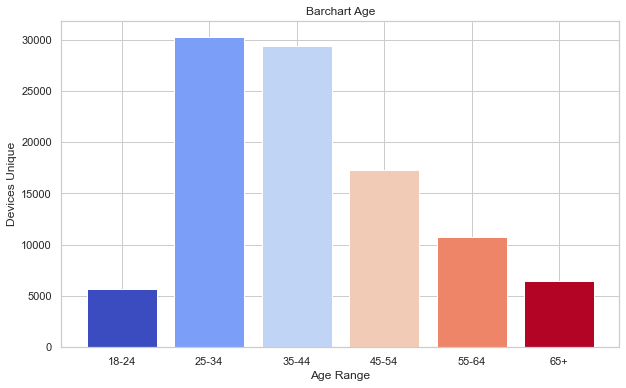

In [133]:
#Grafico de barras
fig = plt.gcf()
fig.set_size_inches(10, 6) 

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

height = data['device_idx'].to_list()
bars = data.index #('A', 'B', 'C', 'D', 'E')
y_pos = np.arange(len(bars))
 
# Create bars and choose color
plt.bar(y_pos, height, color=my_cmap(rescale(y_pos)))
 
# Add title and axis names
plt.title('Barchart Age')
plt.xlabel('Age Range')
plt.ylabel('Devices Unique')
 
# # Limits for the Y axis
# plt.ylim(0,60)
 
# Create names
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()

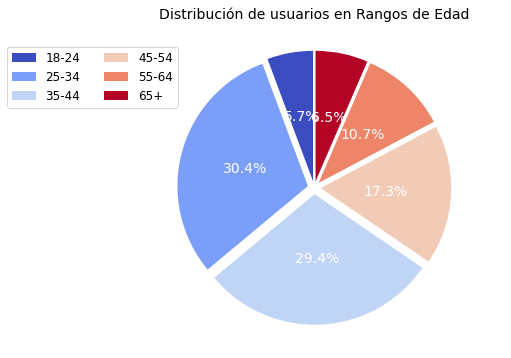

In [33]:
#Using matplotlib piechart
pie, ax = plt.subplots(figsize=[8,6])
colors = my_cmap(rescale(y_pos)) #["#8390FA","#1D2F6F"]
plt.pie(x=data['device_idx'], autopct="%.1f%%", explode=[0.05]*6, labels=data.index, pctdistance=0.5, colors=colors,\
        textprops={'color':"w",'fontsize': 14},startangle=90)
plt.legend(['18-24', '25-34', '35-44', '45-54', '55-64','65+'], loc='upper right',bbox_to_anchor=(0.1,0.95), ncol = 2,\
           fontsize=12)
plt.title("Distribución de usuarios en Rangos de Edad", fontsize=14);

Como feature engenireeng se aplicará en principio lo mismo que en el caso género.   
Es decir, agrupacion de features en nuevas variables con valor "Otros" para aquellos que presenten muy pocos devices asociados.   
También se aplicaría la generación de rubros en el estudio de dominios.   
Al analizar en detalle las urls visitadas por usuarios, se arma la matriz de dominios de esos sitios versus cantidad de veces que el usuario navegó en el mismo.   
Esto daría una idea de la intensidad en el interés por páginas web de un dominio particular.

#### Algunos gráficos exploratorios

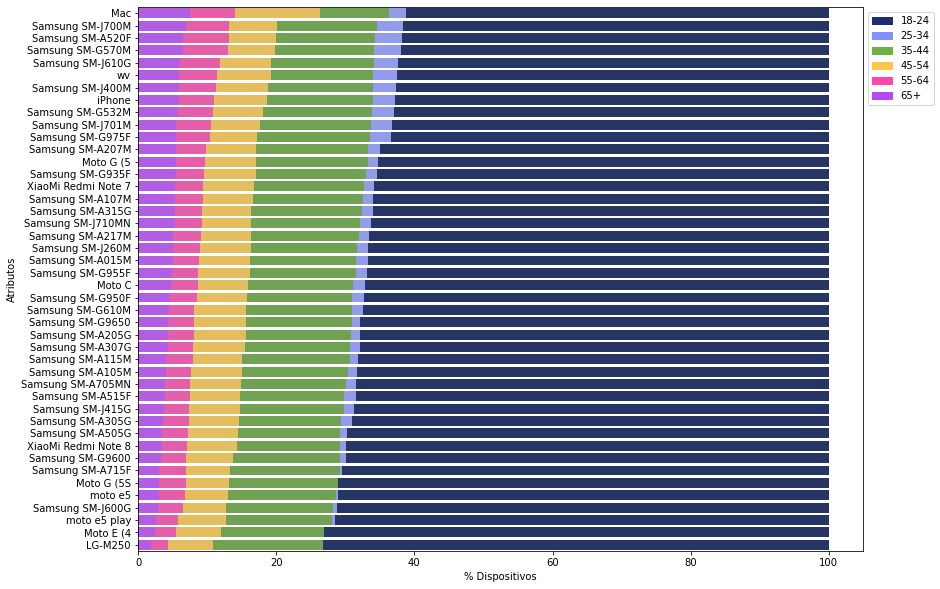

In [84]:
## load dataset
data = df_demo.copy()
data = data[data['feature_type']=='df']
tips = data.copy()

# set the figure size
plt.figure(figsize=(13, 10))

# from raw value to percentage
total = tips.groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_1824 = tips[tips.label==4].groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_1824['nunique'] = [i / j * 100 for i,j in zip(df_1824['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
df_1824 = df_1824.sort_values('nunique', ascending=False)

total = tips.groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_2534 = tips[tips.label==5].groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_2534['nunique'] = [i / j * 100 for i,j in zip(df_2534['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
df_2534 = df_2534.sort_values('nunique', ascending=False)

total = tips.groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_3544 = tips[tips.label==6].groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_3544['nunique'] = [i / j * 100 for i,j in zip(df_3544['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
df_3544 = df_3544.sort_values('nunique', ascending=False)

total = tips.groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_4554 = tips[tips.label==7].groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_4554['nunique'] = [i / j * 100 for i,j in zip(df_4554['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
df_4554 = df_4554.sort_values('nunique', ascending=False)

total = tips.groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_5564 = tips[tips.label==8].groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_5564['nunique'] = [i / j * 100 for i,j in zip(df_5564['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
df_5564 = df_5564.sort_values('nunique', ascending=False)

total = tips.groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_mas65 = tips[tips.label==9].groupby('feature_detail')['device_idx'].agg(['nunique']).reset_index()
df_mas65['nunique'] = [i / j * 100 for i,j in zip(df_mas65['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
#total = total.sort_values('nunique', ascending=False)
df_mas65 = df_mas65.sort_values('nunique', ascending=False)

# bar chart 1 -> top bars (group of 'delayed=No')
bar1 = sns.barplot(x="nunique",  y="feature_detail", data=total, color='#1D2F6F')

# # bar chart 2 -> bottom bars (group of 'delayed=Yes')
# bar2 = sns.barplot(x="nunique", y="feature_detail", data=df_1824, color='#4A235A')

# bar chart 2 -> bottom bars (group of 'delayed=Yes')
bar3 = sns.barplot(x="nunique", y="feature_detail", data=df_2534, color='#8390FA')

# bar chart 1 -> top bars (group of 'delayed=No')
bar4= sns.barplot(x="nunique",  y="feature_detail", data=df_3544, color='#6EAF46')

# bar chart 2 -> bottom bars (group of 'delayed=Yes')
bar5 = sns.barplot(x="nunique", y="feature_detail", data=df_4554, color='#FAC748')

# bar chart 1 -> top bars (group of 'delayed=No')
bar6 = sns.barplot(x="nunique",  y="feature_detail", data=df_5564, color='#FA48AD')

# bar chart 2 -> bottom bars (group of 'delayed=Yes')
bar7 = sns.barplot(x="nunique", y="feature_detail", data=df_mas65, color='#B648FA')

# add legend
import matplotlib.patches as mpatches
top_bar = mpatches.Patch(color='#1D2F6F', label='18-24')
bottom_bar = mpatches.Patch(color='#8390FA', label='25-34')
top_bar1 = mpatches.Patch(color='#6EAF46', label='35-44')
bottom_bar1 = mpatches.Patch(color='#FAC748', label='45-54')
top_bar2 = mpatches.Patch(color='#FA48AD', label='55-64')
bottom_bar2 = mpatches.Patch(color='#B648FA', label='65+')
plt.legend(handles=[top_bar,bottom_bar,top_bar1,bottom_bar1,top_bar2,bottom_bar2], bbox_to_anchor=(1,1))
plt.xlabel("% Dispositivos")
plt.ylabel("Atributos")
# show the graph
plt.show()

In [128]:
data = df_demo.copy()
df_completo_edad_ar = data[['device_idx','feature_detail', 'label']]
df_gropued_age_ar = df_completo_edad_ar.groupby(['feature_detail','label']).nunique()
df_gropued_age_ar = df_gropued_age_ar.reset_index()
df_gropued_age_ar = df_gropued_age_ar.pivot(index='feature_detail', columns='label', values='device_idx')
df_gropued_age_ar = df_gropued_age_ar.reset_index()
df_gropued_age_ar = df_gropued_age_ar.fillna(0)
df_gropued_age_ar = df_gropued_age_ar.sort_values([4,5,6,7,8,9], ascending=False)
df_gropued_age_ar 

df_gropued_age_ar['total'] = df_gropued_age_ar[4] + df_gropued_age_ar[5] +df_gropued_age_ar[6] +df_gropued_age_ar[7] +df_gropued_age_ar[8] +df_gropued_age_ar[9]
df_gropued_age_ar['porc_1824'] = df_gropued_age_ar[4] / df_gropued_age_ar['total']
df_gropued_age_ar['porc_2534'] = df_gropued_age_ar[5] / df_gropued_age_ar['total']
df_gropued_age_ar['porc_3544'] = df_gropued_age_ar[6] / df_gropued_age_ar['total']
df_gropued_age_ar['porc_4554'] = df_gropued_age_ar[7] / df_gropued_age_ar['total']
df_gropued_age_ar['porc_5564'] = df_gropued_age_ar[8] / df_gropued_age_ar['total']
df_gropued_age_ar['porc_65'] = df_gropued_age_ar[9] / df_gropued_age_ar['total']
df_gropued_age_ar = df_gropued_age_ar[['feature_detail','porc_1824','porc_2534','porc_3544','porc_4554','porc_5564','porc_65']]
df_gropued_age_ar = df_gropued_age_ar.set_index('feature_detail')
df_gropued_age_ar = df_gropued_age_ar.stack().to_frame().reset_index()
df_gropued_age_ar = df_gropued_age_ar.rename(columns={0:'porc_age'})
df_gropued_age_ar

,feature_detail,label,porc_age
0,1,porc_1824,0.057307
1,1,porc_2534,0.304213
2,1,porc_3544,0.293076
3,1,porc_4554,0.173023
4,1,porc_5564,0.107260
...,...,...,...
191863,encuestanacional.org/cocina/gracias.php,porc_2534,0.000000
191864,encuestanacional.org/cocina/gracias.php,porc_3544,0.000000
191865,encuestanacional.org/cocina/gracias.php,porc_4554,0.100000
191866,encuestanacional.org/cocina/gracias.php,porc_5564,0.400000


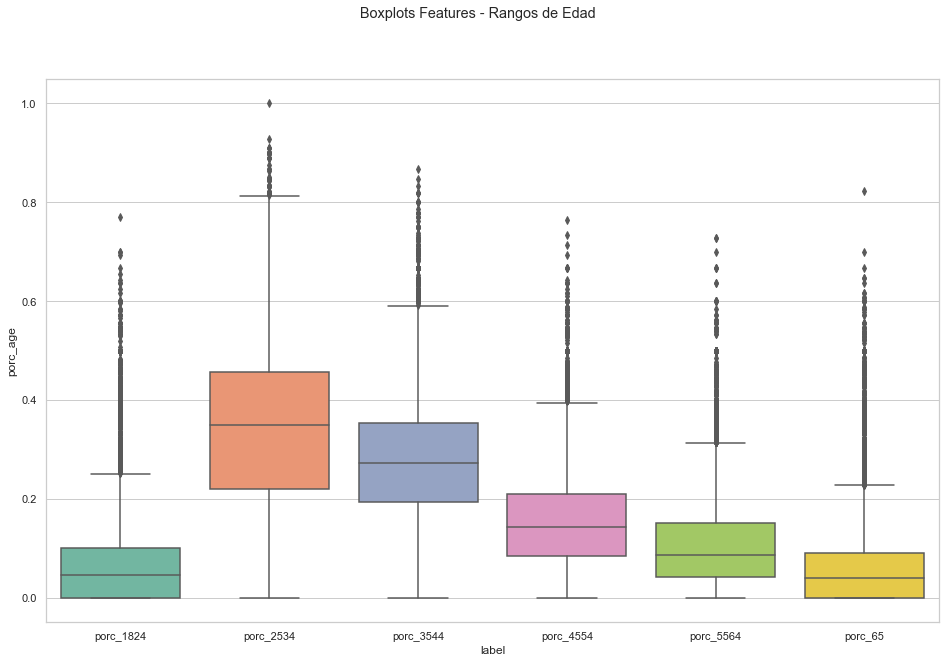

In [129]:
df_gropued_age_ar_ = df_gropued_age_ar
fig = plt.gcf()
fig.set_size_inches(16, 10)
fig.suptitle('Boxplots Features - Rangos de Edad')
sns.set_theme(style="whitegrid")
tips = df_gropued_age_ar_
ax = sns.boxplot(x="label", y="porc_age", data=tips, palette="Set2")

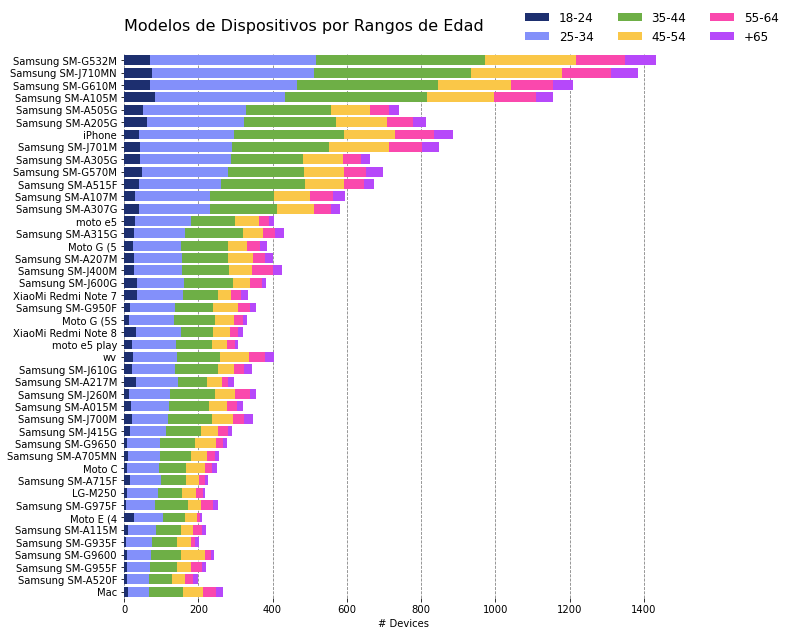

In [58]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='df']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(10, 10))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Modelos de Dispositivos por Rangos de Edad\n', loc='left', fontsize=16)
plt.legend(labels, bbox_to_anchor=([0.70, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

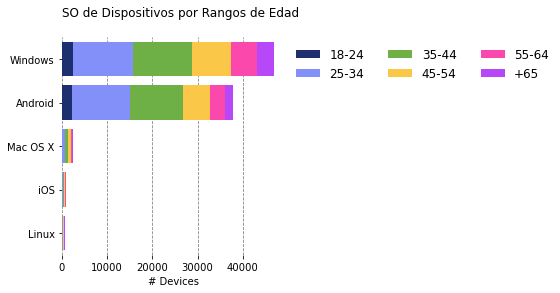

In [114]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='of']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4, 4))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('SO de Dispositivos por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

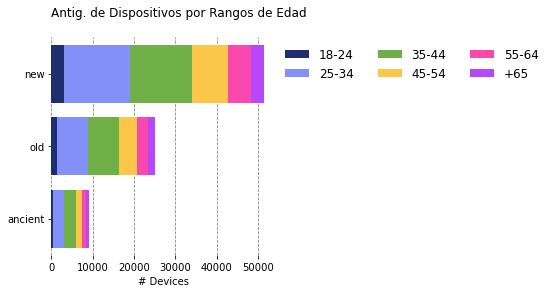

In [113]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='oa']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4, 4))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Antig. de Dispositivos por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

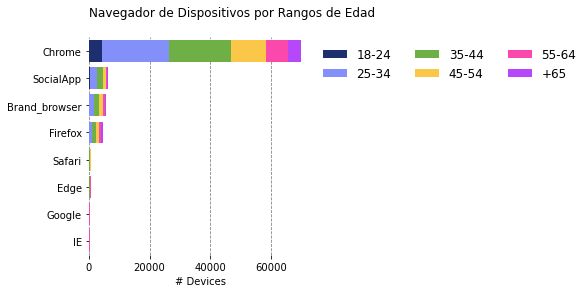

In [112]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='bf']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4, 4))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Navegador de Dispositivos por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

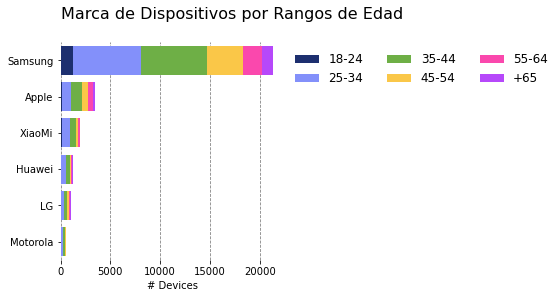

In [98]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='db']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4, 4))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Marca de Dispositivos por Rangos de Edad\n', loc='left', fontsize=16)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

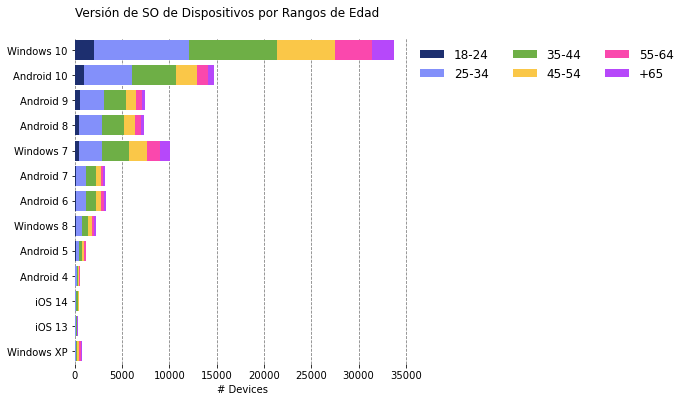

In [111]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='ov']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Versión de SO de Dispositivos por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

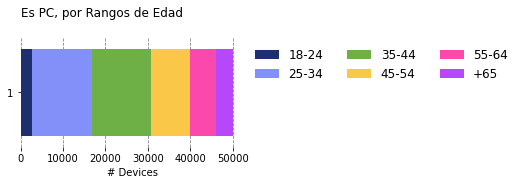

In [110]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='ip']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4,2))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Es PC, por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

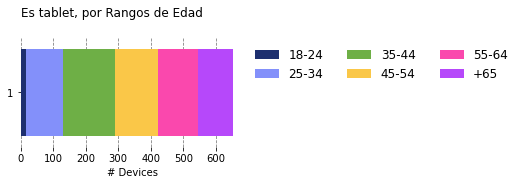

In [109]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='it']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4, 2))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Es tablet, por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

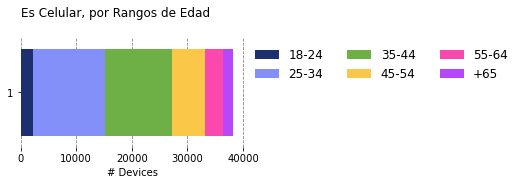

In [108]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='im']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped#.head(100)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4,2))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Es Celular, por Rangos de Edad\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

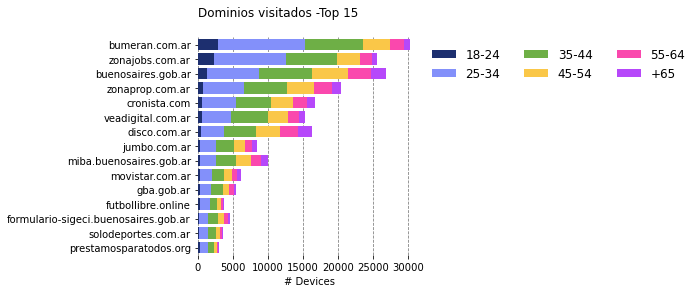

In [107]:
data = df_demo.copy()
db_labels_age = data[(data['label']==4) | (data['label']==5)|(data['label']==6) | (data['label']==7)|(data['label']==8) | (data['label']==9)]
db_labels_age = db_labels_age[db_labels_age['feature_type']=='dom']
db_labels_age = db_labels_age.groupby(['label','feature_detail']).nunique().sort_values('device_idx', ascending=False)#.head(100)

db_labels_age = db_labels_age.reset_index()
db_labels_age = db_labels_age.pivot(index='feature_detail', columns='label', values='device_idx')

db_labels_age = db_labels_age.sort_values(5.0, ascending=False)

df_grouped = db_labels_age.copy()
df_grouped = df_grouped.head(15)
df_grouped = df_grouped.sort_values(5.0, ascending=True) 
fields = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#FA48AD', '#B648FA']
labels = ['18-24', '25-34','35-44', '45-54','55-64', '+65']
# figure and axis
fig, ax = plt.subplots(1, figsize=(4, 4))
# plot bars
left = len(df_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
    left = left + df_grouped[name]
# title, legend, labels
plt.title('Dominios visitados -Top 15\n', loc='left', fontsize=12)
plt.legend(labels, bbox_to_anchor=([1.0, 1, 0, 0]), ncol=3, frameon=False, fontsize=12)
plt.xlabel('# Devices')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

Distribución de visitas por dominio


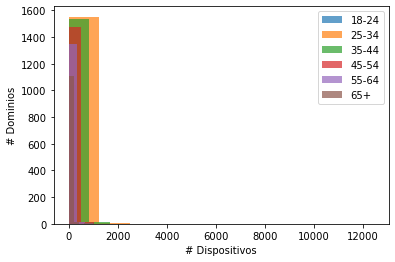

In [120]:
data = df_demo.copy()
data = data[data['feature_type']=='dom']
visitas_4 = pd.DataFrame(data[data['label']==4]['feature_detail'].value_counts()).rename(columns={'feature_detail':'# Dispositivos'})
visitas_5 = pd.DataFrame(data[data['label']==5]['feature_detail'].value_counts()).rename(columns={'feature_detail':'# Dispositivos'})
visitas_6 = pd.DataFrame(data[data['label']==6]['feature_detail'].value_counts()).rename(columns={'feature_detail':'# Dispositivos'})
visitas_7 = pd.DataFrame(data[data['label']==7]['feature_detail'].value_counts()).rename(columns={'feature_detail':'# Dispositivos'})
visitas_8 = pd.DataFrame(data[data['label']==8]['feature_detail'].value_counts()).rename(columns={'feature_detail':'# Dispositivos'})
visitas_9 = pd.DataFrame(data[data['label']==9]['feature_detail'].value_counts()).rename(columns={'feature_detail':'# Dispositivos'})

print('Distribución de visitas por dominio')
fig, ax = plt.subplots()  #histogramas
# plot a kernel density estimation over a stacked barchart
v1=visitas_4['# Dispositivos']
v2=visitas_5['# Dispositivos']
v3=visitas_6['# Dispositivos']
v4=visitas_7['# Dispositivos']
v5=visitas_8['# Dispositivos']
v6=visitas_9['# Dispositivos']
plt.hist(v1, alpha=0.7, label='18-24'); #desde -50 a 150, de 5 en 5
plt.hist(v2, alpha=0.7, label='25-34');
plt.hist(v3, alpha=0.7, label='35-44'); #desde -50 a 150, de 5 en 5
plt.hist(v4, alpha=0.7, label='45-54')
plt.hist(v5, alpha=0.7, label='55-64'); #desde -50 a 150, de 5 en 5
plt.hist(v6, alpha=0.7, label='65+')
plt.legend()
plt.xlabel("# Dispositivos")
plt.ylabel("# Dominios");

#ax.set(xlim=(0,5000))

### DATA MODEL - ADAPTATION